In [1]:
import os
import struct
import sys
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import numpy as np
import mindspore
import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore import context
from mindspore.nn.metrics import Accuracy
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore import Tensor
context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')

In [2]:
cfg = edict({
 'train_size': 60000, # 训练集大小
 'test_size': 10000, # 测试集大小
 'channel': 1, # 图片通道数
 'image_height': 28, # 图片高度
    'image_width': 28, # 图片宽度
 'batch_size': 64,
 'num_classes': 10, # 分类类别
 'lr': 0.001, # 学习率
 'epoch_size': 20, # 训练次数
 'data_dir_train': os.path.join('fashion-mnist', 'train'),
 'data_dir_test': os.path.join('fashion-mnist', 'test'),
})


In [3]:
def read_image(file_name):
 '''
 :param file_name: 文件路径
 :return: 训练或者测试数据
 如下是训练的图片的二进制格式
 [offset] [type] [value] [description]
 0000 32 bit integer 0x00000803(2051) magic number
 0004 32 bit integer 60000 number of images
 0008 32 bit integer 28 number of rows
 0012 32 bit integer 28 number of columns
 0016 unsigned byte ?? pixel
 0017 unsigned byte ?? pixel
 ........
 xxxx unsigned byte ?? pixel
 '''
 file_handle = open(file_name, "rb") # 以二进制打开文档
 file_content = file_handle.read() # 读取到缓冲区中
 head = struct.unpack_from('>IIII', file_content, 0) # 取前 4 个整数，返回一个元组
 offset = struct.calcsize('>IIII')
 imgNum = head[1] # 图片数
 width = head[2] # 宽度
 height = head[3] # 高度
 bits = imgNum * width * height # data 一共有 60000*28*28 个像素值
 bitsString = '>' + str(bits) + 'B' # fmt 格式：'>47040000B'
 imgs = struct.unpack_from(bitsString, file_content, offset) # 取 data 数据，返回一个元组
 imgs_array = np.array(imgs, np.float32).reshape((imgNum, width * height)) 
# 最后将读取的数据 reshape 成 【图片数，图片像素】二维数组
 return imgs_array
def read_label(file_name):
 '''
 :param file_name:
 :return:
 标签的格式如下：
 [offset] [type] [value] [description]
 0000 32 bit integer 0x00000801(2049) magic number (MSB first)
 0004 32 bit integer 60000 number of items
 0008 unsigned byte ?? label
 0009 unsigned byte ?? label
 ........
 xxxx unsigned byte ?? label
 The labels values are 0 to 9.
 '''
 file_handle = open(file_name, "rb") # 以二进制打开文档
 file_content = file_handle.read() # 读取到缓冲区中
 head = struct.unpack_from('>II', file_content, 0) # 取前 2 个整数，返回一个元组
 offset = struct.calcsize('>II')
 labelNum = head[1] # label 数
 bitsString = '>' + str(labelNum) + 'B' # fmt 格式：'>47040000B'
 label = struct.unpack_from(bitsString, file_content, offset) # 取 data 数据，返回一个元组
 return np.array(label, np.int32)
def get_data():
 # 文件获取
 train_image = os.path.join(cfg.data_dir_train, 'train-images-idx3-ubyte')
 test_image = os.path.join(cfg.data_dir_test, "t10k-images-idx3-ubyte")
 train_label = os.path.join(cfg.data_dir_train, "train-labels-idx1-ubyte")
 test_label = os.path.join(cfg.data_dir_test, "t10k-labels-idx1-ubyte")
 # 读取数据
 train_x = read_image(train_image)
 test_x = read_image(test_image)
 train_y = read_label(train_label)
 test_y = read_label(test_label)
 return train_x, train_y, test_x, test_y

训练数据集样本数： 60000
测试数据集样本数： 10000
通道数/图像长/宽： (1, 28, 28)
一张图像的标签样式： 9


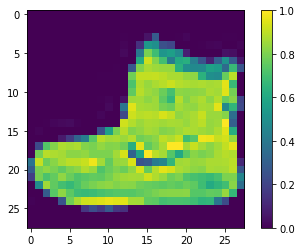

In [4]:
train_x, train_y, test_x, test_y = get_data()
train_x = train_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
test_x = test_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
train_x = train_x / 255.0
test_x = test_x / 255.0
print('训练数据集样本数：', train_x.shape[0])
print('测试数据集样本数：', test_y.shape[0])
print('通道数/图像长/宽：', train_x.shape[1:])
print('一张图像的标签样式：', train_y[0]) # 一共 10 类，用 0-9 的数字表达类别。
plt.figure()
plt.imshow(train_x[0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

In [5]:
# 转换数据类型为 Dataset
def create_dataset():
 XY_train = list(zip(train_x, train_y))
 ds_train = ds.GeneratorDataset(XY_train, ['x', 'y'])
 ds_train = ds_train.shuffle(buffer_size=1000).batch(cfg.batch_size, 
drop_remainder=True)
 XY_test = list(zip(test_x, test_y))
 ds_test = ds.GeneratorDataset(XY_test, ['x', 'y'])
 ds_test = ds_test.shuffle(buffer_size=1000).batch(cfg.batch_size, 
drop_remainder=True)
 return ds_train, ds_test

In [6]:
# 定义卷积神经网络，无正则化
class ForwardFashion(nn.Cell):
 def __init__(self, num_class=10): # 一共分十类，图片通道数是 1
  super(ForwardFashion, self).__init__()
  self.num_class = num_class
  self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
  self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
  self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
  self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
  self.relu = nn.ReLU()
  self.flatten = nn.Flatten()
  self.fc1 = nn.Dense(128 * 11 * 11, 128)
  self.fc2 = nn.Dense(128, self.num_class)
 def construct(self, x):
  x = self.conv1(x)
  x = self.relu(x)
  x = self.conv2(x)
  x = self.relu(x)
  x = self.conv3(x)
  x = self.relu(x)
  x = self.maxpool2d(x)
  x = self.flatten(x)
  x = self.fc1(x)
  x = self.relu(x)
  x = self.fc2(x)
  return x

In [7]:
# 定义卷积神经网络，有正则化
class ForwardFashionRegularization(nn.Cell):
    def __init__(self, num_class=10): # 一共分十类，图片通道数是 1
        super(ForwardFashionRegularization, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(3200, 128)
        self.bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Dense(128, self.num_class)
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [8]:
def train(Net):
    ds_train, ds_test = create_dataset()
 # 构建网络
    network = Net(cfg.num_classes)
 # 定义模型的损失函数，优化器
    net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
 # 训练模型
    model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'acc': Accuracy()})
    loss_cb = LossMonitor()
    print("============== Starting Training ==============")
    model.train(30, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
 # 验证
    metric = model.eval(ds_test)
    print(metric)
    return model

In [9]:
# 训练无正则化的网络
model = train(ForwardFashion)

============== Starting Training ==============
epoch: 1 step: 937, loss is 0.3344201445579529
epoch: 2 step: 937, loss is 0.2689235508441925
epoch: 3 step: 937, loss is 0.18394631147384644
epoch: 4 step: 937, loss is 0.17498475313186646
epoch: 5 step: 937, loss is 0.23030441999435425
epoch: 6 step: 937, loss is 0.27919113636016846
epoch: 7 step: 937, loss is 0.034674741327762604
epoch: 8 step: 937, loss is 0.10159452259540558
epoch: 9 step: 937, loss is 0.17314723134040833
epoch: 10 step: 937, loss is 0.10550688207149506
epoch: 11 step: 937, loss is 0.11099457740783691
epoch: 12 step: 937, loss is 0.09299320727586746
epoch: 13 step: 937, loss is 0.006471050437539816
epoch: 14 step: 937, loss is 0.07411222159862518
epoch: 15 step: 937, loss is 0.03250378742814064
epoch: 16 step: 937, loss is 0.0021490901708602905
epoch: 17 step: 937, loss is 0.07589889317750931
epoch: 18 step: 937, loss is 0.004510070197284222
epoch: 19 step: 937, loss is 0.0029475258197635412
epoch: 20 step: 937, loss

In [10]:
# 训练有正则化的网络
model = train(ForwardFashionRegularization)

============== Starting Training ==============


[WARNING] DEVICE(5253,ffff9868e780,python):2023-04-26-19:04:15.672.476 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[DropoutGenMask] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(5253,ffff9868e780,python):2023-04-26-19:04:15.682.979 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[DropoutGenMask] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(5253,ffff9868e780,python):2023-04-26-19:04:15.689.592 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[DropoutGenMask] don't support int64, reduce precision from int64 to int32.


epoch: 1 step: 937, loss is 0.3667970299720764
epoch: 2 step: 937, loss is 0.22414608299732208
epoch: 3 step: 937, loss is 0.27774012088775635
epoch: 4 step: 937, loss is 0.2107868790626526
epoch: 5 step: 937, loss is 0.34461814165115356
epoch: 6 step: 937, loss is 0.30979910492897034
epoch: 7 step: 937, loss is 0.2601698935031891
epoch: 8 step: 937, loss is 0.3264274597167969
epoch: 9 step: 937, loss is 0.2099684178829193
epoch: 10 step: 937, loss is 0.28509652614593506
epoch: 11 step: 937, loss is 0.2969682216644287
epoch: 12 step: 937, loss is 0.46438682079315186
epoch: 13 step: 937, loss is 0.34476515650749207
epoch: 14 step: 937, loss is 0.3082510530948639
epoch: 15 step: 937, loss is 0.1348818838596344
epoch: 16 step: 937, loss is 0.355733186006546
epoch: 17 step: 937, loss is 0.1296483427286148
epoch: 18 step: 937, loss is 0.27990639209747314
epoch: 19 step: 937, loss is 0.21178963780403137
epoch: 20 step: 937, loss is 0.24720506370067596
epoch: 21 step: 937, loss is 0.222555041

In [11]:
# 预测
ds_test, _ = create_dataset()
test_ = ds_test.create_dict_iterator(output_numpy=True).__next__()
predictions = model.predict(Tensor(test_['x']))
predictions = predictions.asnumpy()
for i in range(15):
    p_np = predictions[i, :]
    p_list = p_np.tolist()
    print('第' + str(i) + '个 sample 预测结果：', p_list.index(max(p_list)), ' 真实结果：', test_['y'][i])

第0个 sample 预测结果： 5  真实结果： 5
第1个 sample 预测结果： 4  真实结果： 4
第2个 sample 预测结果： 9  真实结果： 9
第3个 sample 预测结果： 6  真实结果： 6
第4个 sample 预测结果： 3  真实结果： 3
第5个 sample 预测结果： 0  真实结果： 0
第6个 sample 预测结果： 4  真实结果： 4
第7个 sample 预测结果： 9  真实结果： 9
第8个 sample 预测结果： 1  真实结果： 1
第9个 sample 预测结果： 9  真实结果： 9
第10个 sample 预测结果： 4  真实结果： 4
第11个 sample 预测结果： 6  真实结果： 6
第12个 sample 预测结果： 2  真实结果： 2
第13个 sample 预测结果： 7  真实结果： 7
第14个 sample 预测结果： 0  真实结果： 0


In [20]:
# -------------------定义可视化函数--------------------------------
# 输入预测结果序列，真实标签序列，以及图片序列
# 预测
# 目标是根据预测值对错，让其标签显示为红色或者蓝色。对：标签为红色；错：标签为蓝色
import numpy as np
def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
 # 显示对应图片
    plt.imshow(img, cmap=plt.cm.binary)
 # 显示预测结果的颜色，如果对上了是蓝色，否则为红色
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
 # 显示对应标签的格式，样式
    plt.xlabel('{},{:2.0f}% ({})'.format(class_names[predicted_label],100 * np.max(predictions_array),class_names[true_label]), color=color)
# 将预测的结果以柱状图形状显示蓝对红错
def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    this_plot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    this_plot[predicted_label].set_color('red')
    this_plot[true_label].set_color('blue')

def softmax_np(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x/np.sum(exp_x)
    return softmax_x

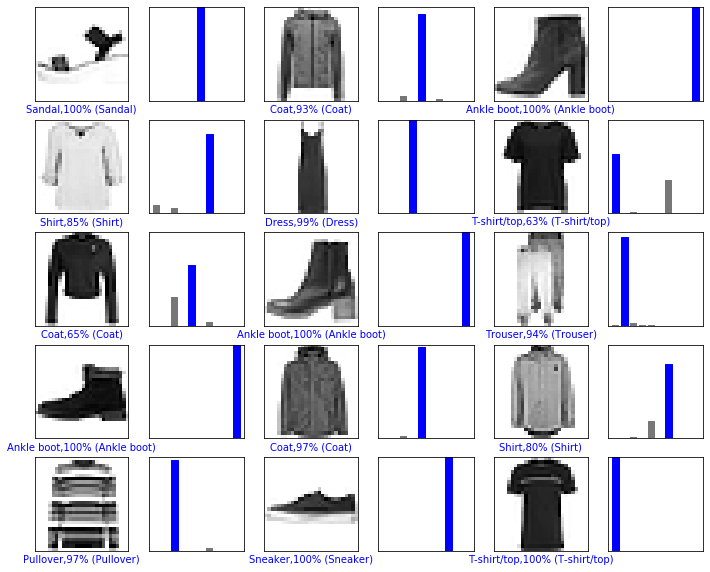

In [21]:
# 预测 15 个图像与标签，并展现出来
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(num_images):
     plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
     pred_np_ = predictions[i, :]
     pred_np_ = softmax_np(pred_np_)
     plot_image(pred_np_, test_['y'][i], test_['x'][i, 0, ...])
     plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
     plot_value_array(pred_np_, test_['y'][i])
plt.show()